Dataset loaded: 88 samples
Features: 12 dimensions
Target statistics: Mean=75.30, Std=8.66
Starting Leave-One-Out Cross-Validation with Original BloodPressureNN...
Total iterations: 88
Note: Training takes longer due to 1000 epochs per fold
Fold 86/88
Cross-validation completed!

SIMPLIFIED MODEL PERFORMANCE COMPARISON

BLOODPRESSURE NN:
----------------------------------------
  MAE            : 5.0246
  RMSE           : 6.3352
  R²             : 0.4587
  Mean_Residual  : 0.1710
  Std_Residual   : 6.3328

LINEAR MODEL:
----------------------------------------
  MAE            : 5.1924
  RMSE           : 6.4385
  R²             : 0.4409
  Mean_Residual  : -0.0649
  Std_Residual   : 6.4382

RIDGE REGRESSION:
----------------------------------------
  MAE            : 5.1123
  RMSE           : 6.3682
  R²             : 0.4530
  Mean_Residual  : -0.0139
  Std_Residual   : 6.3682

RANDOM FOREST:
----------------------------------------
  MAE            : 4.7841
  RMSE           : 6.7091
  

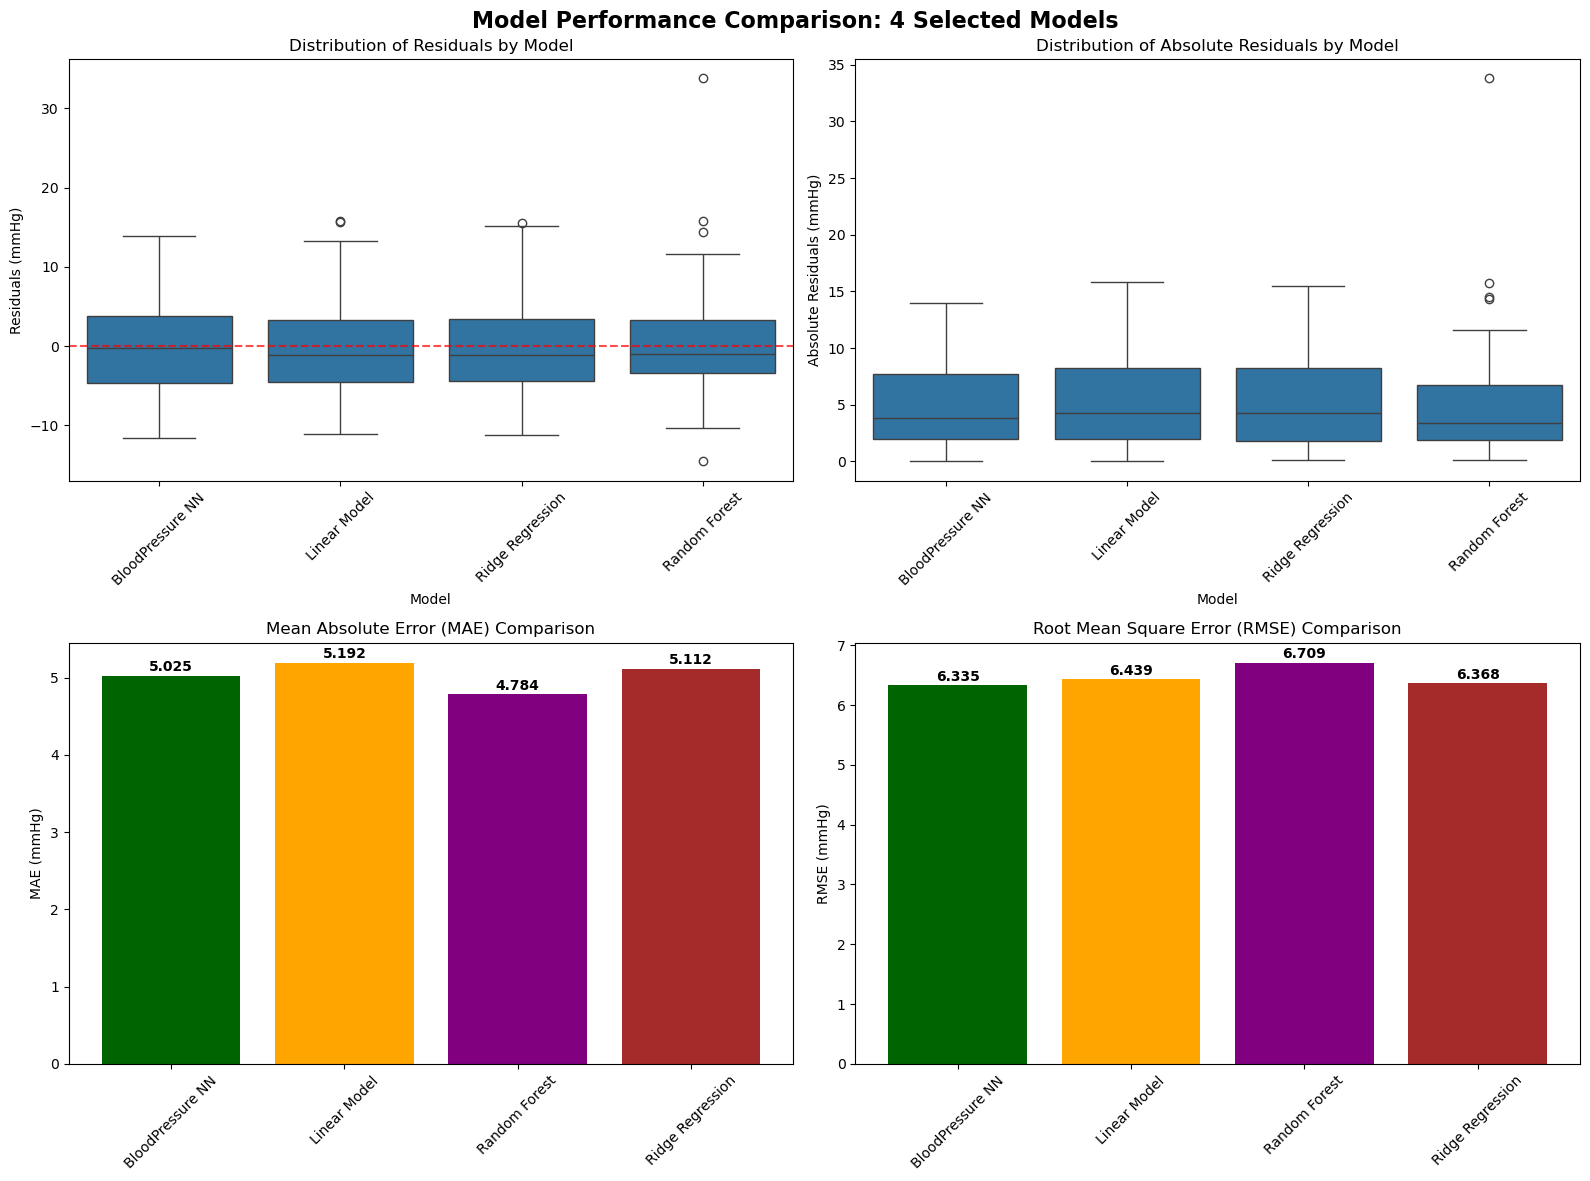

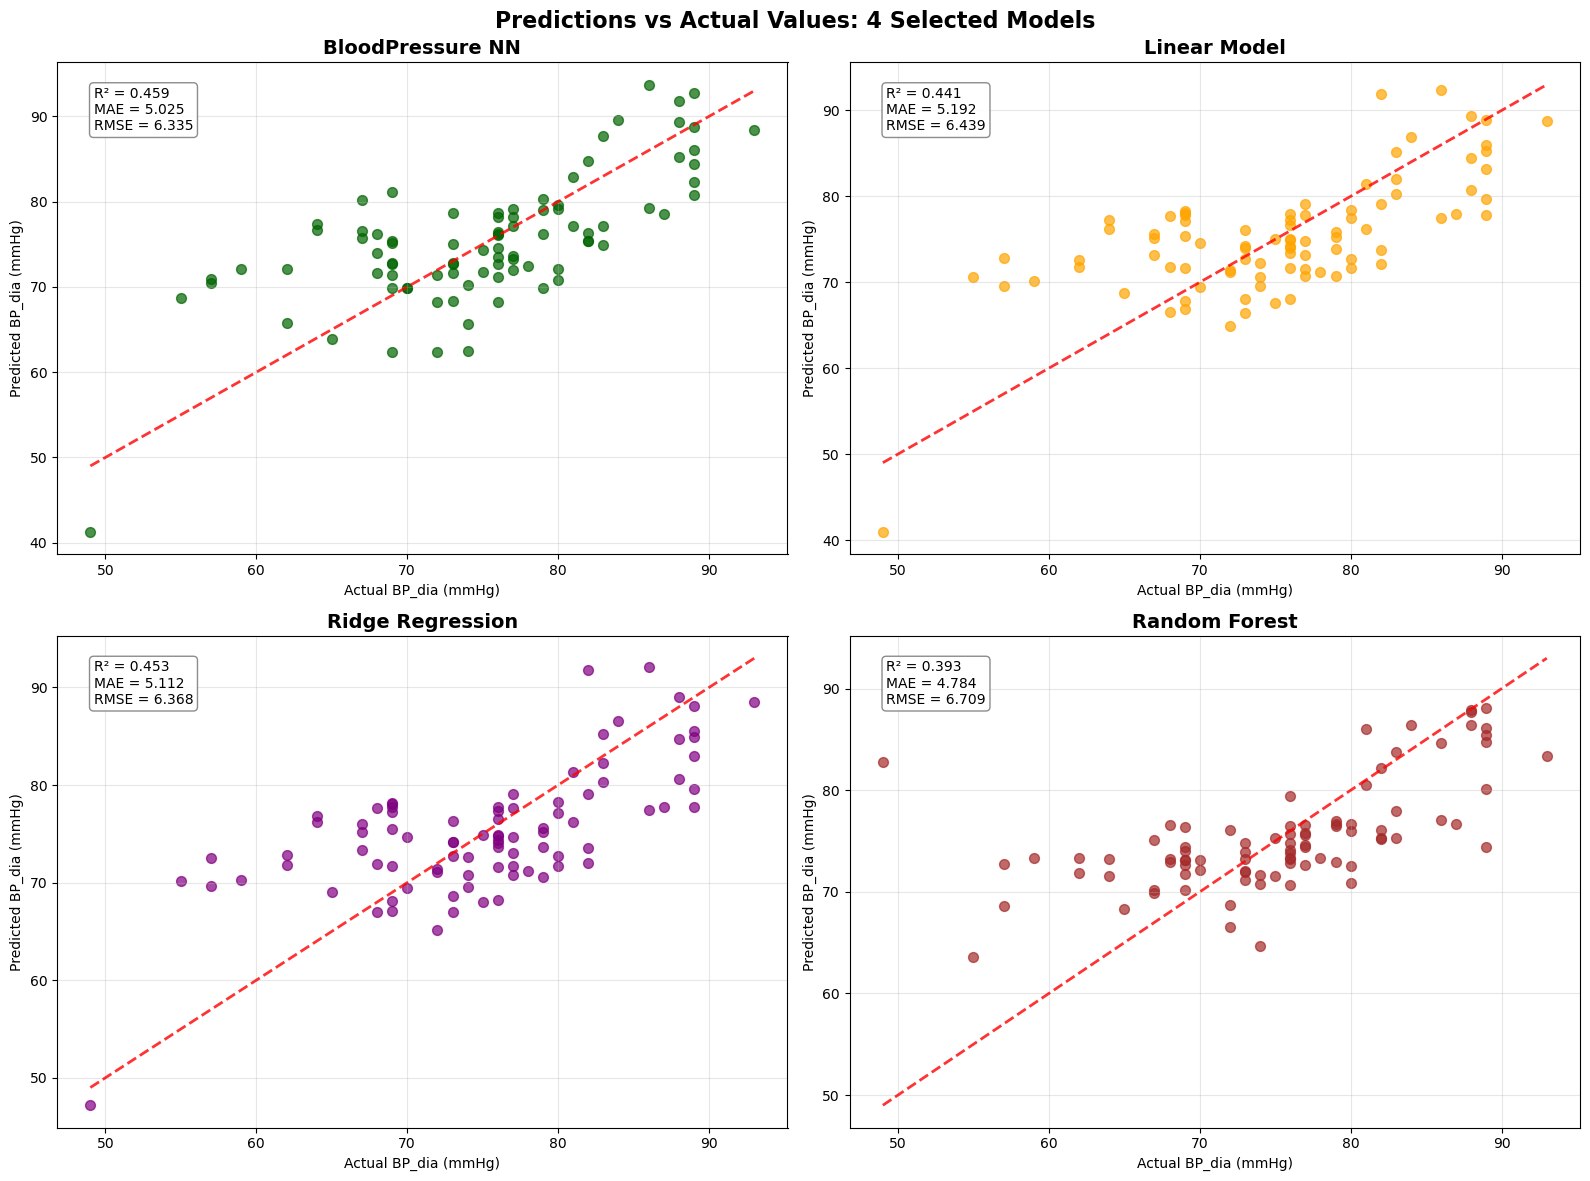

In [10]:
# Verbesserte Konfiguration für multidimensionale Daten
HIDDEN_DIM = 64  # Größer für 12 Input-Features
LEARNING_RATE = 1e-3  # Konservativ
WEIGHT_DECAY = 1e-4   # Leichte Regularisierung
EPOCHS = 200          # Mehr Epochs für komplexere Patterns

class MultidimensionalBloodPressureNN(nn.Module):
    """Neural Network designed for multidimensional physiological data"""
    
    def __init__(self, input_size, hidden_dim):
        super(MultidimensionalBloodPressureNN, self).__init__()
        
        # Feature-spezifische Verarbeitung
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Tiefere Architektur für komplexe Patterns
        self.hidden_layers = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Output layer
        self.output = nn.Linear(hidden_dim // 4, 1)
        
        # Gewichtsinitialisierung
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Handle single sample (batch size 1) für BatchNorm
        if x.size(0) == 1:
            # Für Leave-One-Out: Manuelle Forward-Pass ohne BatchNorm
            was_training = self.training
            self.eval()
            with torch.no_grad():
                # Feature extraction manually
                features = self.feature_extractor[0](x)  # Linear layer
                features = F.relu(features)
                features = F.dropout(features, p=0.2, training=False)
                
                # Hidden layers manually
                hidden = self.hidden_layers[0](features)  # Linear layer
                hidden = F.relu(hidden)
                hidden = F.dropout(hidden, p=0.3, training=False)
                
                hidden = self.hidden_layers[4](hidden)  # Second linear layer
                hidden = F.relu(hidden)
                hidden = F.dropout(hidden, p=0.3, training=False)
                
                hidden = self.hidden_layers[8](hidden)  # Third linear layer
                hidden = F.relu(hidden)
                hidden = F.dropout(hidden, p=0.2, training=False)
                
                output = self.output(hidden)
            
            if was_training:
                self.train()
            return output
        else:
            features = self.feature_extractor(x)
            hidden = self.hidden_layers(features)
            return self.output(hidden)

# Original BloodPressureNN aus dem anderen Code
class BloodPressureNN(nn.Module):
    """Neural Network for Blood Pressure Estimation"""
    
    def __init__(self, input_size, hidden_dim):
        super(BloodPressureNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

def train_original_neural_network(model, X, y, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, epochs=EPOCHS):
    """Train neural network using the original simple approach"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(X).reshape(-1)
        loss = criterion(output, y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
    
    return model

# Robuste Alternative ohne BatchNorm-Probleme
class RobustBloodPressureNN(nn.Module):
    """Robustes Neural Network ohne BatchNorm für Leave-One-Out"""
    
    def __init__(self, input_size, hidden_dim):
        super(RobustBloodPressureNN, self).__init__()
        
        # Einfache aber effektive Architektur ohne BatchNorm
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim // 4, 1)
        )
        
        # Gewichtsinitialisierung
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.layers(x)

def train_advanced_neural_network(model, X, y, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, epochs=EPOCHS):
    """Advanced training with learning rate scheduling"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)
    criterion = nn.MSELoss()
    
    model.train()
    best_loss = float('inf')
    patience = 50
    patience_counter = 0
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(X).reshape(-1)
        loss = criterion(output, y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step(loss)
        
        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return model

# Ensemble von verschiedenen NN-Architekturen
class EnsembleMultiNN(nn.Module):
    """Ensemble of different neural network architectures"""
    
    def __init__(self, input_size, hidden_dim):
        super(EnsembleMultiNN, self).__init__()
        
        # Verschiedene Architekturen
        self.nn1 = MultidimensionalBloodPressureNN(input_size, hidden_dim)
        self.nn2 = ResidualBloodPressureNN(input_size, hidden_dim // 2)
        
        # Simple deep network
        self.nn3 = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, x):
        pred1 = self.nn1(x)
        pred2 = self.nn2(x)
        pred3 = self.nn3(x)
        
        # Weighted average (kann trainiert werden)
        return (pred1 + pred2 + pred3) / 3

def main_advanced():
    """Main function with advanced neural networks"""
    # Load data
    df = pd.read_csv(DATA_FILE, sep='\t')
    print(f"Dataset loaded: {len(df)} samples")
    print(f"Features: {len(FEATURE_COLS)} dimensions")
    print(f"Target statistics: Mean={df[TARGET_COL].mean():.2f}, Std={df[TARGET_COL].std():.2f}")
    
    # Results storage
    results = {
        'Multidimensional_NN': [],
        'Residual_NN': [],
        'Ensemble_NN': [],
        'Linear_Model': [],
        'Ridge_Regression': [],
        'Random_Forest': []
    }
    
    # Store actual values for final comparison
    actual_values = []
    
    # Leave-One-Out Cross-Validation
    loo = LeaveOneOut()
    print("Starting Leave-One-Out Cross-Validation...")
    print(f"Total iterations: {len(df)}")
    
    for fold, (train_idx, test_idx) in enumerate(loo.split(df)):
        if fold % 20 == 0:
            print(f"\rFold {fold + 1}/{len(df)}", end="")
        
        # Split data
        train_data = df.iloc[train_idx]
        test_data = df.iloc[test_idx]
        
        # Store actual value
        actual_values.append(test_data[TARGET_COL].values[0])
        
        # Prepare data with standardization
        X_train, y_train, scaler = prepare_data_with_scaling(train_data, FEATURE_COLS, TARGET_COL)
        X_test, y_test, _ = prepare_data_with_scaling(test_data, FEATURE_COLS, TARGET_COL, 
                                                     scaler=scaler, fit_scaler=False)
        
        # Train different Neural Networks
        multi_nn = MultidimensionalBloodPressureNN(input_size=len(FEATURE_COLS), hidden_dim=HIDDEN_DIM)
        multi_nn = train_advanced_neural_network(multi_nn, X_train, y_train)
        
        residual_nn = ResidualBloodPressureNN(input_size=len(FEATURE_COLS), hidden_dim=HIDDEN_DIM)
        residual_nn = train_advanced_neural_network(residual_nn, X_train, y_train)
        
        ensemble_nn = EnsembleMultiNN(input_size=len(FEATURE_COLS), hidden_dim=HIDDEN_DIM)
        ensemble_nn = train_advanced_neural_network(ensemble_nn, X_train, y_train, epochs=150)
        
        # Train other models
        lm_model = train_linear_model(train_data, FEATURE_COLS, TARGET_COL)
        ridge_model = train_ridge_regression(X_train.numpy(), y_train.numpy())
        rf_model = train_random_forest(X_train.numpy(), y_train.numpy())
        
        # Make predictions
        multi_nn.eval()
        residual_nn.eval()
        ensemble_nn.eval()
        
        with torch.no_grad():
            multi_pred = multi_nn(X_test).detach().numpy().flatten()[0]
            residual_pred = residual_nn(X_test).detach().numpy().flatten()[0]
            ensemble_pred = ensemble_nn(X_test).detach().numpy().flatten()[0]
        
        lm_pred = lm_model.predict(test_data).values[0]
        ridge_pred = ridge_model.predict(X_test.numpy())[0]
        rf_pred = rf_model.predict(X_test.numpy())[0]
        
        # Store results
        results['Multidimensional_NN'].append(multi_pred)
        results['Residual_NN'].append(residual_pred)
        results['Ensemble_NN'].append(ensemble_pred)
        results['Linear_Model'].append(lm_pred)
        results['Ridge_Regression'].append(ridge_pred)
        results['Random_Forest'].append(rf_pred)
    
    print("\nCross-validation completed!")
    
    # Convert to numpy arrays
    actual_values = np.array(actual_values)
    
    # Calculate metrics for all models
    print("\n" + "="*70)
    print("ADVANCED MODEL PERFORMANCE COMPARISON")
    print("="*70)
    
    model_metrics = {}
    for model_name, predictions in results.items():
        predictions = np.array(predictions)
        metrics = calculate_metrics(predictions, actual_values)
        model_metrics[model_name] = metrics
        
        print(f"\n{model_name.replace('_', ' ').upper()}:")
        print("-" * 40)
        for metric, value in metrics.items():
            print(f"  {metric:15}: {value:.4f}")
    
    # Find best model
    best_model = min(model_metrics.keys(), key=lambda k: model_metrics[k]['MAE'])
    print(f"\n🏆 BEST MODEL: {best_model.replace('_', ' ').upper()}")
    print(f"   MAE: {model_metrics[best_model]['MAE']:.4f} mmHg")
    print(f"   RMSE: {model_metrics[best_model]['RMSE']:.4f} mmHg")
    print(f"   R²: {model_metrics[best_model]['R²']:.4f}")
    
    # Create visualization
    create_advanced_comparison_plots(results, actual_values, model_metrics)
    
    return results, actual_values, model_metrics

def create_advanced_comparison_plots(results, actual_values, model_metrics):
    """Create advanced comparison plots for 6 models"""
    
    # Prepare data for plotting
    plot_data = []
    for model_name, predictions in results.items():
        residuals = np.array(predictions) - actual_values
        mae = model_metrics[model_name]['MAE']
        rmse = model_metrics[model_name]['RMSE']
        
        for residual in residuals:
            plot_data.append({
                'Model': model_name.replace('_', ' '),
                'Residual': residual,
                'Absolute_Residual': abs(residual),
                'MAE': mae,
                'RMSE': rmse
            })
    
    df_plot = pd.DataFrame(plot_data)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Advanced Model Performance Comparison for Blood Pressure Estimation', 
                 fontsize=16, fontweight='bold')
    
    # 1. Boxplot of Residuals
    sns.boxplot(data=df_plot, x='Model', y='Residual', ax=axes[0,0])
    axes[0,0].set_title('Distribution of Residuals by Model')
    axes[0,0].set_ylabel('Residuals (mmHg)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # 2. Boxplot of Absolute Residuals
    sns.boxplot(data=df_plot, x='Model', y='Absolute_Residual', ax=axes[0,1])
    axes[0,1].set_title('Distribution of Absolute Residuals by Model')
    axes[0,1].set_ylabel('Absolute Residuals (mmHg)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. MAE Comparison
    mae_data = df_plot.groupby('Model')['MAE'].first().reset_index()
    bars1 = axes[1,0].bar(mae_data['Model'], mae_data['MAE'], 
                         color=['navy', 'darkgreen', 'darkred', 'orange', 'purple', 'brown'])
    axes[1,0].set_title('Mean Absolute Error (MAE) Comparison')
    axes[1,0].set_ylabel('MAE (mmHg)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 4. RMSE Comparison
    rmse_data = df_plot.groupby('Model')['RMSE'].first().reset_index()
    bars2 = axes[1,1].bar(rmse_data['Model'], rmse_data['RMSE'], 
                         color=['navy', 'darkgreen', 'darkred', 'orange', 'purple', 'brown'])
    axes[1,1].set_title('Root Mean Square Error (RMSE) Comparison')
    axes[1,1].set_ylabel('RMSE (mmHg)')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Predictions vs Actual for Neural Networks only
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Neural Network Predictions vs Actual Values', fontsize=16, fontweight='bold')
    
    nn_models = ['Multidimensional_NN', 'Residual_NN', 'Ensemble_NN']
    colors = ['blue', 'green', 'red']
    
    for i, model_name in enumerate(nn_models):
        predictions = np.array(results[model_name])
        
        axes[i].scatter(actual_values, predictions, alpha=0.6, color=colors[i])
        axes[i].plot([actual_values.min(), actual_values.max()], 
                    [actual_values.min(), actual_values.max()], 
                    'r--', lw=2)
        axes[i].set_xlabel('Actual BP_dia (mmHg)')
        axes[i].set_ylabel('Predicted BP_dia (mmHg)')
        axes[i].set_title(f'{model_name.replace("_", " ")}')
        
        # Add metrics to plot
        r2 = model_metrics[model_name]['R²']
        mae = model_metrics[model_name]['MAE']
        axes[i].text(0.05, 0.95, f'R² = {r2:.3f}\nMAE = {mae:.3f}', 
                    transform=axes[i].transAxes, 
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Verbesserte main_advanced Funktion mit robustem NN
def main_robust():
    """Main function with original BloodPressureNN"""
    # Load data
    df = pd.read_csv(DATA_FILE, sep='\t')
    print(f"Dataset loaded: {len(df)} samples")
    print(f"Features: {len(FEATURE_COLS)} dimensions")
    print(f"Target statistics: Mean={df[TARGET_COL].mean():.2f}, Std={df[TARGET_COL].std():.2f}")
    
    # Results storage - BloodPressureNN statt Residual NN
    results = {
        'BloodPressure_NN': [],
        'Linear_Model': [],
        'Ridge_Regression': [],
        'Random_Forest': []
    }
    
    # Store actual values for final comparison
    actual_values = []
    
    # Leave-One-Out Cross-Validation
    loo = LeaveOneOut()
    print("Starting Leave-One-Out Cross-Validation with Original BloodPressureNN...")
    print(f"Total iterations: {len(df)}")
    print("Note: Training takes longer due to 1000 epochs per fold")
    
    for fold, (train_idx, test_idx) in enumerate(loo.split(df)):
        if fold % 5 == 0:  # Öftere Updates wegen längerem Training
            print(f"\rFold {fold + 1}/{len(df)}", end="", flush=True)
        
        # Split data
        train_data = df.iloc[train_idx]
        test_data = df.iloc[test_idx]
        
        # Store actual value
        actual_values.append(test_data[TARGET_COL].values[0])
        
        # Prepare data - sowohl mit als auch ohne Standardisierung für verschiedene Modelle
        X_train, y_train, scaler = prepare_data_with_scaling(train_data, FEATURE_COLS, TARGET_COL)
        X_test, y_test, _ = prepare_data_with_scaling(test_data, FEATURE_COLS, TARGET_COL, 
                                                     scaler=scaler, fit_scaler=False)
        
        # Prepare data ohne Standardisierung für das originale NN
        X_train_orig = torch.tensor(train_data[FEATURE_COLS].values.astype(np.float32))
        y_train_orig = torch.tensor(train_data[TARGET_COL].values.astype(np.float32))
        X_test_orig = torch.tensor(test_data[FEATURE_COLS].values.astype(np.float32))
        
        # Train das originale BloodPressureNN (ohne Standardisierung wie im Original)
        bp_nn = BloodPressureNN(input_size=len(FEATURE_COLS), hidden_dim=50)  # Original hidden_dim
        bp_nn = train_original_neural_network(bp_nn, X_train_orig, y_train_orig, epochs=1000)  # Original epochs
        
        # Train other models
        lm_model = train_linear_model(train_data, FEATURE_COLS, TARGET_COL)
        ridge_model = train_ridge_regression(X_train.numpy(), y_train.numpy())
        rf_model = train_random_forest(X_train.numpy(), y_train.numpy())
        
        # Make predictions
        bp_nn.eval()
        
        with torch.no_grad():
            bp_pred = bp_nn(X_test_orig).detach().numpy().flatten()[0]
        
        lm_pred = lm_model.predict(test_data).values[0]
        ridge_pred = ridge_model.predict(X_test.numpy())[0]
        rf_pred = rf_model.predict(X_test.numpy())[0]
        
        # Store results
        results['BloodPressure_NN'].append(bp_pred)
        results['Linear_Model'].append(lm_pred)
        results['Ridge_Regression'].append(ridge_pred)
        results['Random_Forest'].append(rf_pred)
    
    print("\nCross-validation completed!")
    
    # Convert to numpy arrays
    actual_values = np.array(actual_values)
    
    # Calculate metrics for all models
    print("\n" + "="*70)
    print("SIMPLIFIED MODEL PERFORMANCE COMPARISON")
    print("="*70)
    
    model_metrics = {}
    for model_name, predictions in results.items():
        predictions = np.array(predictions)
        metrics = calculate_metrics(predictions, actual_values)
        model_metrics[model_name] = metrics
        
        print(f"\n{model_name.replace('_', ' ').upper()}:")
        print("-" * 40)
        for metric, value in metrics.items():
            print(f"  {metric:15}: {value:.4f}")
    
    # Find best model
    best_model = min(model_metrics.keys(), key=lambda k: model_metrics[k]['MAE'])
    print(f"\n🏆 BEST MODEL: {best_model.replace('_', ' ').upper()}")
    print(f"   MAE: {model_metrics[best_model]['MAE']:.4f} mmHg")
    print(f"   RMSE: {model_metrics[best_model]['RMSE']:.4f} mmHg")
    print(f"   R²: {model_metrics[best_model]['R²']:.4f}")
    
    # Create visualization
    create_simplified_comparison_plots(results, actual_values, model_metrics)
    
    return results, actual_values, model_metrics

def create_simplified_comparison_plots(results, actual_values, model_metrics):
    """Create comparison plots for 4 selected models"""
    
    # Prepare data for plotting
    plot_data = []
    for model_name, predictions in results.items():
        residuals = np.array(predictions) - actual_values
        mae = model_metrics[model_name]['MAE']
        rmse = model_metrics[model_name]['RMSE']
        
        for residual in residuals:
            plot_data.append({
                'Model': model_name.replace('_', ' '),
                'Residual': residual,
                'Absolute_Residual': abs(residual),
                'MAE': mae,
                'RMSE': rmse
            })
    
    df_plot = pd.DataFrame(plot_data)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Comparison: 4 Selected Models', 
                 fontsize=16, fontweight='bold')
    
    # 1. Boxplot of Residuals
    sns.boxplot(data=df_plot, x='Model', y='Residual', ax=axes[0,0])
    axes[0,0].set_title('Distribution of Residuals by Model')
    axes[0,0].set_ylabel('Residuals (mmHg)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # 2. Boxplot of Absolute Residuals
    sns.boxplot(data=df_plot, x='Model', y='Absolute_Residual', ax=axes[0,1])
    axes[0,1].set_title('Distribution of Absolute Residuals by Model')
    axes[0,1].set_ylabel('Absolute Residuals (mmHg)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. MAE Comparison
    mae_data = df_plot.groupby('Model')['MAE'].first().reset_index()
    bars1 = axes[1,0].bar(mae_data['Model'], mae_data['MAE'], 
                         color=['darkgreen', 'orange', 'purple', 'brown'])
    axes[1,0].set_title('Mean Absolute Error (MAE) Comparison')
    axes[1,0].set_ylabel('MAE (mmHg)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 4. RMSE Comparison
    rmse_data = df_plot.groupby('Model')['RMSE'].first().reset_index()
    bars2 = axes[1,1].bar(rmse_data['Model'], rmse_data['RMSE'], 
                         color=['darkgreen', 'orange', 'purple', 'brown'])
    axes[1,1].set_title('Root Mean Square Error (RMSE) Comparison')
    axes[1,1].set_ylabel('RMSE (mmHg)')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Predictions vs Actual for all 4 models
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Predictions vs Actual Values: 4 Selected Models', fontsize=16, fontweight='bold')
    
    model_names = list(results.keys())
    colors = ['darkgreen', 'orange', 'purple', 'brown']
    
    for i, model_name in enumerate(model_names):
        row = i // 2
        col = i % 2
        
        predictions = np.array(results[model_name])
        
        axes[row, col].scatter(actual_values, predictions, alpha=0.7, color=colors[i], s=50)
        axes[row, col].plot([actual_values.min(), actual_values.max()], 
                           [actual_values.min(), actual_values.max()], 
                           'r--', lw=2, alpha=0.8)
        axes[row, col].set_xlabel('Actual BP_dia (mmHg)')
        axes[row, col].set_ylabel('Predicted BP_dia (mmHg)')
        axes[row, col].set_title(f'{model_name.replace("_", " ")}', fontsize=14, fontweight='bold')
        axes[row, col].grid(True, alpha=0.3)
        
        # Add metrics to plot
        r2 = model_metrics[model_name]['R²']
        mae = model_metrics[model_name]['MAE']
        rmse = model_metrics[model_name]['RMSE']
        axes[row, col].text(0.05, 0.95, f'R² = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}', 
                           transform=axes[row, col].transAxes, 
                           verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'),
                           fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Run the robust analysis
if __name__ == "__main__":
    results, actual_values, model_metrics = main_robust()